In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# astronomical units and constants
import astropy.units as u
from astropy.constants import R_sun


from matplotlib.lines import Line2D

import os
CWD = "/".join(os.getcwd().split("/")[:-2])
# Plot stuff
from funcs.model import full_model, aflare

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [43]:
# Datasets we analysed
datasets = [(277539431, "", "08_07_2020_11_48"),
            (237880881, "a", "11_02_2020_10_07"),
            (237880881, "b", "11_02_2020_10_07"),
            (44984200, "", "02_08_2020_17_44"),
            (44984200, "a", "04_08_2020_13_40"),
            (44984200, "b", "04_08_2020_13_40"),
            (100004076, "", "18_08_2020_15_38"),
            ]

In [46]:
ID, suffix, tstamp = datasets[0]

In [47]:
df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}_raw_mcmc_sample.csv")
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
target = props[props.ID == int(ID)].iloc[0]

In [48]:
# Pick up the input parameters
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
inits = inits[(inits.ID == str(ID)) & (inits.tstamp==tstamp)].iloc[0]

qlum = inits.qlum_erg_s * u.erg / u.s
Fth = inits.Fth * u.erg/ u.cm**2 / u.s
median = inits['median']
R = inits.R_Rsun * R_sun

In [49]:
inits

tstamp        08_07_2020_11_48
ID                   277539431
phi_a                      8.1
theta_a                  1.309
a                          1.8
fwhm                   4.96041
Fth                9.06164e+10
phi0                  -2.61799
i_mu                   1.52021
i_sigma              0.0416149
radius_deg             15.3169
R_Rsun                0.145216
qlum_erg_s         1.12637e+30
median                 778.056
log_prob       log_probability
nparam                       6
Name: 27, dtype: object

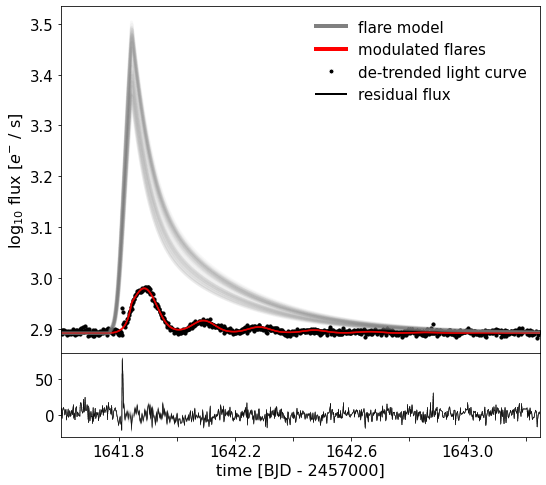

In [94]:

N = 50
time = lc.t
phi = lc.phi.values
flux = lc.flux.values

inds = np.random.randint(df.shape[0], size=N)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,7),sharex=True)
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("bottom", size="24%", pad=0)
ax.figure.add_axes(ax2)

ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")

for ind in inds:
    sample = df.loc[ind,]
    phi_a, theta_a, a, fwhm, i, phi0 = sample
    flare = aflare(phi, phi_a, fwhm, a*median)+ median
    fullmodel = full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                           phi=phi, num_pts=50, qlum=qlum,
                           Fth=Fth, R=R, median=median)
    ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
    ax.plot(time, np.log10(fullmodel) , c="r", alpha=0.05)
    ax2.plot(time, flux-fullmodel, c="k", alpha=.05, linewidth=.5)
    
legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                   Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                   Line2D([0], [0], marker='o', color='w', label="de-trended light curve",
                          markerfacecolor='k', markersize=5),
                   Line2D([0], [0], color='k', lw=2, label="residual flux"),
                  ]
ax.legend(handles=legend_elements, fontsize=15, frameon=False)
ax2.set_xlabel(f"time [BJD - {target.BJDoff}]",fontsize=16)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
for label in ax.xaxis.get_ticklabels():
    label.set_visible(False)

ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=16);
plt.tight_layout()
plt.ylim(None, None)
#plt.ylim(608,800)
#plt.ylim(2300,2500)
for axis in [ax, ax2]:
    axis.set_xlim(lc.t.min(), lc.t.max())
plt.savefig(f"{CWD}/analysis/plots/flarefit/"
            f"{tstamp}_{target.prefix}{target.ID}_"
            f"flarefit_{N}retrievals.png",
            dpi=300)